In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterio import features
from rasterio.mask import mask
from shapely.geometry import box
from fiona.crs import from_epsg
from rasterio.plot import show_hist
from matplotlib import pyplot
from rasterio.plot import show
from osgeo import gdal
from osgeo import osr
import rioxarray
import rasterio
from rasterio import features
from rasterstats import zonal_stats
from __future__ import division

## Import Data and Crop GeoTiff

In [2]:
kec_cel=gpd.read_file('Data/kec_2015-celebes.gpkg')
box=box(kec_cel.total_bounds[0], kec_cel.total_bounds[1],
            kec_cel.total_bounds[2], kec_cel.total_bounds[3])
geo_box = gpd.GeoDataFrame({'geometry': box}, index=[0], crs=from_epsg(4326))

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

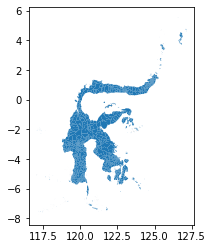

In [3]:
kec_cel.plot()

In [4]:
with rasterio.open('Data/Raw/VNL_v2_npp_2015_global_vcmslcfg_c202102150000.average_masked.tif') as src:
    out_image, out_transform = mask(src, geo_box.geometry, crop=True)
    out_meta = src.meta

In [5]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("Data/NTL_masked_celebes_average.tif", "w", **out_meta) as dest:
    dest.write(out_image)

## Histogram Crop Geotiff 

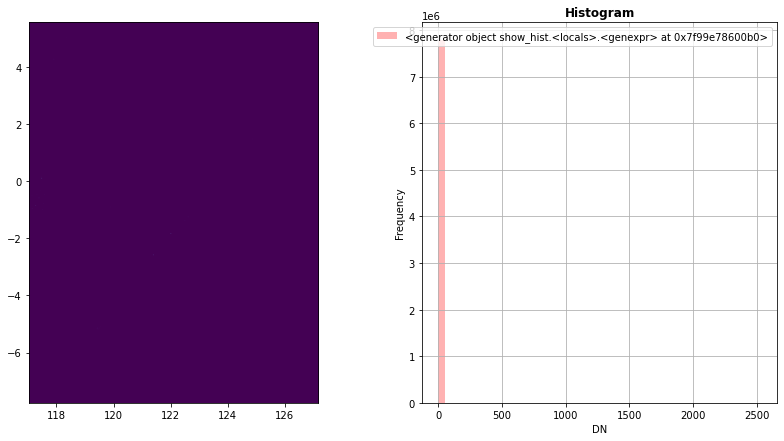

In [6]:
with rasterio.open('Data/NTL_masked_celebes_average.tif') as src:
    fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
    show(src, ax=axrgb)
    show_hist(src, bins=50, histtype='stepfilled',
              lw=0.0, stacked=False, alpha=0.3, ax=axhist)
    pyplot.show()

karena nilainya kecil ==> sepertinya lebih baik di qgis visualisasianya

## Preparing Grid 10m x 10m for Sentinel 2

In [7]:
##set resolution and granularity
grid_resolution=384
sat_granularity=10
grid_size=grid_resolution*sat_granularity

In [8]:
celebes_cea=kec_cel.to_crs('ESRI:53034')
celebes=kec_cel
celebes['IDKEC']=celebes.IDKEC.astype(np.float)

/tmp/ipykernel_22670/810096691.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  celebes['IDKEC']=celebes.IDKEC.astype(np.float)


In [9]:
##geographic extend
GCS_ext=celebes.total_bounds
##projected extend
PCS_ext=celebes_cea.total_bounds

In [10]:
PCS_ext

array([13014085.52287986,  -860120.36167187, 14139987.34080137,
         617917.54650726])

In [11]:
#conversion factor
meter_reciprocal_PC2GCS=(((PCS_ext[2]-PCS_ext[0])/(GCS_ext[2]-GCS_ext[0]))+
                         ((PCS_ext[3]-PCS_ext[1])/(GCS_ext[3]-GCS_ext[1])))/2

resolution=grid_size/meter_reciprocal_PC2GCS

In [12]:
resolution

0.03457604125705496

In [13]:
driver = gdal.GetDriverByName('GTiff')


spatref = osr.SpatialReference()
spatref.ImportFromEPSG(4326)
wkt = spatref.ExportToWkt()

In [14]:
outfn = 'Data/celebes_gcs_S2.tif'
nbands = 1
nodata = 255
xres = resolution
yres = -resolution
xmin = GCS_ext[0]
xmax = GCS_ext[2] 
ymin = GCS_ext[1]
ymax = GCS_ext[3] 
dtype = gdal.GDT_Float32

xsize = abs(int((xmax - xmin) / xres))
ysize = abs(int((ymax - ymin) / yres))

ds = driver.Create(outfn, xsize, ysize, nbands, 
                   dtype, options=['COMPRESS=LZW', 'TILED=YES'])
ds.SetProjection(wkt)
ds.SetGeoTransform([xmin, xres, 0, ymax, 0, yres])
ds.GetRasterBand(1).Fill(0)
ds.GetRasterBand(1).SetNoDataValue(nodata)
ds.FlushCache()
ds = None

In [15]:
rst = rasterio.open('Data/celebes_gcs_S2.tif')
meta = rst.meta.copy()
meta.update(compress='lzw')
with rasterio.open('Data/celebes_gcs_converted_S2.tif', 'w+', **meta) as out:
    out_arr = out.read(1)
    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,IDKEC) for geom,IDKEC in zip(
        celebes.geometry,celebes.IDKEC))
    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

In [16]:
rds = rioxarray.open_rasterio(
    "Data/celebes_gcs_converted_S2.tif",
)
rds = rds.squeeze().drop("spatial_ref").drop("band")
rds.name = "data"
df = rds.to_dataframe().reset_index()
df=df.reset_index()

In [17]:
df=df.query('data!=255')
gdf_=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.x,df.y))

<AxesSubplot:>

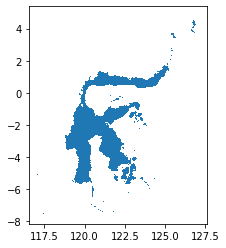

In [18]:
gdf_.geometry=gdf_.buffer(resolution/2,cap_style=3)
gdf_.plot()

## Calculate Zonal Statistics of NTL in Grid Data

In [53]:
def mean_(x):
    if (x>0).sum()>0:
        return np.sum(x)/((x>0).sum())
    else:
        return 0
def count_(x):
    return (x>0).sum()

In [54]:
mean_zon=pd.DataFrame(
    zonal_stats(
        vectors=gdf_['geometry'], 
        raster='Data/NTL_masked_celebes_average.tif', 
        stats=['mean','count','sum'],
        add_stats={'mean_weight':mean_,'count_weight':count_}
    )
)

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [55]:
zonal_stat_grid=gdf_.reset_index()[['data','geometry']].merge(mean_zon,left_index=True,right_index=True)

In [56]:
zonal_stat_grid[['mean','mean_weight','sum','count','count_weight']].describe()

,mean,mean_weight,sum,count,count_weight
count,12690.000000,12690.000000,12690.000000,12690.000000,12690.000000
mean,0.090462,0.144990,6.153181,68.871001,3.719622
std,1.708639,1.724896,110.853340,5.376237,11.381686
min,0.000000,0.000000,0.000000,64.000000,0.000000
25%,0.000000,0.000000,0.000000,64.000000,0.000000
50%,0.000000,0.000000,0.000000,72.000000,0.000000
75%,0.000000,0.000000,0.000000,72.000000,0.000000
max,175.325378,175.325378,11220.824219,81.000000,81.000000


In [58]:
zonal_stat_grid.to_file('Result/zonal_stat_grid_S2.gpkg',driver='GPKG')

## Preparing Grid 15m x 15m for LANDSAT8

In [59]:
##set resolution and granularity
grid_resolution=256
sat_granularity=15
grid_size=grid_resolution*sat_granularity

In [60]:
celebes_cea=kec_cel.to_crs('ESRI:53034')
celebes=kec_cel
celebes['IDKEC']=celebes.IDKEC.astype(np.float)

/tmp/ipykernel_22670/810096691.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  celebes['IDKEC']=celebes.IDKEC.astype(np.float)


In [61]:
##geographic extend
GCS_ext=celebes.total_bounds
##projected extend
PCS_ext=celebes_cea.total_bounds

In [62]:
PCS_ext

array([13014085.52287986,  -860120.36167187, 14139987.34080137,
         617917.54650726])

In [63]:
#conversion factor
meter_reciprocal_PC2GCS=(((PCS_ext[2]-PCS_ext[0])/(GCS_ext[2]-GCS_ext[0]))+
                         ((PCS_ext[3]-PCS_ext[1])/(GCS_ext[3]-GCS_ext[1])))/2

resolution=grid_size/meter_reciprocal_PC2GCS

In [64]:
resolution

0.03457604125705496

In [65]:
driver = gdal.GetDriverByName('GTiff')


spatref = osr.SpatialReference()
spatref.ImportFromEPSG(4326)
wkt = spatref.ExportToWkt()

In [66]:
outfn = 'Data/celebes_gcs_L8.tif'
nbands = 1
nodata = 255
xres = resolution
yres = -resolution
xmin = GCS_ext[0]
xmax = GCS_ext[2] 
ymin = GCS_ext[1]
ymax = GCS_ext[3] 
dtype = gdal.GDT_Float32

xsize = abs(int((xmax - xmin) / xres))
ysize = abs(int((ymax - ymin) / yres))

ds = driver.Create(outfn, xsize, ysize, nbands, 
                   dtype, options=['COMPRESS=LZW', 'TILED=YES'])
ds.SetProjection(wkt)
ds.SetGeoTransform([xmin, xres, 0, ymax, 0, yres])
ds.GetRasterBand(1).Fill(0)
ds.GetRasterBand(1).SetNoDataValue(nodata)
ds.FlushCache()
ds = None

In [67]:
rst = rasterio.open('Data/celebes_gcs_L8.tif')
meta = rst.meta.copy()
meta.update(compress='lzw')
with rasterio.open('Data/celebes_gcs_converted_L8.tif', 'w+', **meta) as out:
    out_arr = out.read(1)
    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,IDKEC) for geom,IDKEC in zip(
        celebes.geometry,celebes.IDKEC))
    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

In [68]:
rds = rioxarray.open_rasterio(
    "Data/celebes_gcs_converted_L8.tif",
)
rds = rds.squeeze().drop("spatial_ref").drop("band")
rds.name = "data"
df = rds.to_dataframe().reset_index()
df=df.reset_index()

In [69]:
df=df.query('data!=255')
gdf_=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.x,df.y))

<AxesSubplot:>

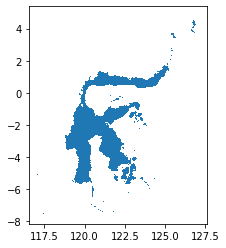

In [70]:
gdf_.geometry=gdf_.buffer(resolution/2,cap_style=3)
gdf_.plot()

## Calculate Zonal Statistics of NTL in Grid Data

In [74]:
mean_zon=pd.DataFrame(
    zonal_stats(
        vectors=gdf_['geometry'], 
        raster='Data/NTL_masked_celebes_average.tif', 
        stats=['mean','count','sum'],
        add_stats={'mean_weight':mean_,'count_weight':count_}
    )
)

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [75]:
zonal_stat_grid=gdf_.reset_index()[['data','geometry']].merge(mean_zon,left_index=True,right_index=True)

In [76]:
zonal_stat_grid[['mean','mean_weight','sum','count','count_weight']].describe()

,mean,mean_weight,sum,count,count_weight
count,12690.000000,12690.000000,12690.000000,12690.000000,12690.000000
mean,0.090462,0.144990,6.153181,68.871001,3.719622
std,1.708639,1.724896,110.853340,5.376237,11.381686
min,0.000000,0.000000,0.000000,64.000000,0.000000
25%,0.000000,0.000000,0.000000,64.000000,0.000000
50%,0.000000,0.000000,0.000000,72.000000,0.000000
75%,0.000000,0.000000,0.000000,72.000000,0.000000
max,175.325378,175.325378,11220.824219,81.000000,81.000000


In [77]:
zonal_stat_grid.to_file('Result/zonal_stat_grid_L8.gpkg',driver='GPKG')